# One-shot Adversarial Training (Siamese Verification Networks and Traditional Adversarial Training)

In this notebook, we investigate one-shot learning for adversarial robustness. We take our undefended models and apply traditional adversarial training to them (injecting adversarial examples into training data), but in a one-shot setting, meaning that only a single adversarial example per output class is injected into the training data.

After creating these traditionally adversarially trained models, we create siamese verification neural networks, also trained in a one-shot fashion, as an alternative defence for our undefended neural network models.

IMPORTANT: This notebook is computationally intensive and requires a large amount of RAM. If you are running this notebook on low-end hardware e.g. a standard laptop, the kernel may run out of memory if too many other processes are running. If you encounter this issue, restarting your device releases enough RAM to run the notebook in its entirety. Clearing your browser's cache also helps.

#### Importing helper functions and imports.

In [1]:
#!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans
%run "utils_imports.ipynb" # import libraries and helper functions
%run "utils_attacks.ipynb"
%run "utils_data.ipynb"
%run "utils_helper.ipynb"
%run "utils_training.ipynb"
%run "siamese_attack_variants.ipynb"

## Loading the undefended models and their datasets

In this section, we load our undefended neural network models and preprocess their datasets via helper functions from 'data_utils.ipynb'.

In [3]:
#get the face recognition model's architecture
%run utils_face_model_architecture.ipynb
face_model = model

(56, 46, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 56, 46, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 56, 46, 1)]  0           []                               
                                                                                                  
 embedding (Sequential)         (None, 128)          200528      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['embedding[0][0]

In [4]:
#loading the library
mnist_model = tf.keras.models.load_model("../models/FF_digit_classification_model_l2_regularised.model")
speech_model = tf.keras.models.load_model("../models/speechcommandsNN")
traffic_model = tf.keras.models.load_model("../models/traffic_model/trafficsignNN_normalised.h5")
face_model.load_weights("../models/face_siamese_weights/siamesefacepredictorweights.h5")

### MNIST

In [5]:
# get the mnist dataset via data_utils
mnist_x_train, mnist_x_test, mnist_y_train, mnist_y_test = get_mnist_dataset()

print('Number of images in MNIST train dataset: ',len(mnist_x_train))

Number of images in MNIST train dataset:  60000


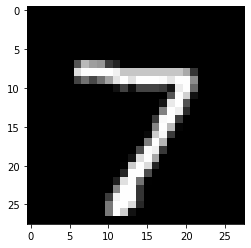

In [6]:
#visualising the data
plt.imshow(mnist_x_test[0], cmap='gray')

### Traffic Sign dataset

In [7]:
#get traffic dataset via data_utils
traffic_x_train, traffic_x_test, traffic_y_train, traffic_y_test = get_traffic_dataset()
print(traffic_x_train.shape, traffic_x_test.shape, traffic_y_train.shape, traffic_y_test.shape)

(3440, 30, 30, 3) (860, 30, 30, 3) (3440, 43) (860, 43)


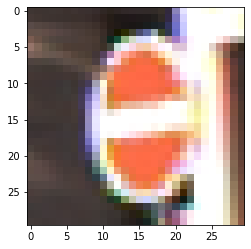

In [8]:
plt.imshow(traffic_x_test[0])

### Speech Commands dataset

In [9]:
#get speech commands dataset via data_utils
speech_x_train, speech_x_test, speech_y_train, speech_y_test = get_speech_dataset()

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']
Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'..\\data\\mini_speech_commands\\left\\15d83b54_nohash_1.wav', shape=(), dtype=string)
Training set size 6400
Validation set size 800
Test set size 800


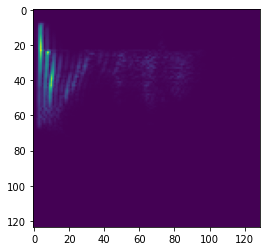

In [10]:
plt.imshow(speech_x_test[0]) # visualising the spectrogram images

### Face Dataset

This dataset consists of pairs of images, labelled either as 0 for a false match, or 1 for a true match.

In [11]:
face_x, face_y = get_face_data()
face_x_train, face_x_test, face_y_train, face_y_test = train_test_split(face_x, face_y, test_size=.25)
print(face_x_train.shape, face_x_test.shape)

(15000, 2, 56, 46, 1) (5000, 2, 56, 46, 1)


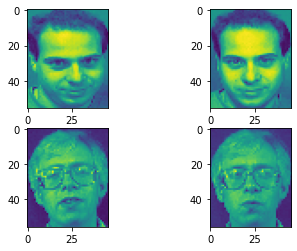

In [12]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(face_x_test[0][0])
axarr[0,1].imshow(face_x_test[0][1])
axarr[1,0].imshow(face_x_test[1][0])
axarr[1,1].imshow(face_x_test[1][1])
plt.show()

## Clean accuracy and loss

Here, we briefly examine the performance of our models on expected data. We evaluate our models in more depth in 'Experiment, Evaluation and Results.ipynb'.

In [13]:
# clean accuracy and loss of models
mnist_clean_accuracy = mnist_model.evaluate(mnist_x_test, mnist_y_test)
traffic_clean_accuracy = traffic_model.evaluate(traffic_x_test, traffic_y_test)
speech_clean_accuracy = speech_model.evaluate(speech_x_test, speech_y_test)
face_clean_accuracy,_,_,face_clean_loss = siamese_model_evaluate(face_model, face_x_test, face_y_test, threshold=0.4)
print('\nMNIST model clean accuracy:', mnist_clean_accuracy[1], ', clean loss: ', mnist_clean_accuracy[0])
print('Traffic Sign Classification model clean accuracy:', traffic_clean_accuracy[1], ', clean loss: ', traffic_clean_accuracy[0])
print('Speech Command Classification clean accuracy:', speech_clean_accuracy[1], ', clean loss: ', speech_clean_accuracy[0])
print('Face Classification clean accuracy:', face_clean_accuracy, ', clean loss: ', face_clean_loss)

25/25 [==============================] - 0s 11ms/step - loss: 0.2752 - accuracy: 0.9150

MNIST model clean accuracy: 0.9577000141143799 , clean loss:  0.3241652846336365
Traffic Sign Classification model clean accuracy: 0.989534854888916 , clean loss:  0.034369710832834244
Speech Command Classification clean accuracy: 0.9150000214576721 , clean loss:  0.2752264738082886
Face Classification clean accuracy: 0.9422 , clean loss:  0.05464536


## Traditional Adversarial Training

Below, we generate a dataset of adversarial examples to attack our siamese face classification model. As we can see, tiny perturbations in each image-pair cause the model's performance to drop drastically. This example also demonstrates the success our attack variants that we have developed. We altered popular adversarial attacks to be able to attack image pairs, and thus, siamese neural networks, which has not been done before to the best of our knowledge. For more detail on these attacks, see 'attack_variants.ipynb'.

The most popular approach to defend models that are vulnerable to adversarial examples is to apply traditional adversarial training to them. Essentially, we inject adversarial examples into the training dataset to increase robustness. However, the performance of this method when restricted to one-shot learning has not been explored, as it is generally only effective when lots of adversarial examples are injected into the dataset.

Therefore, in this section, we generate traditionally adversarially trained models of our vulnerable networks via one-shot learning.

Face Classification model accuracy and loss on adversarial examples:  0.4912 5.5674877


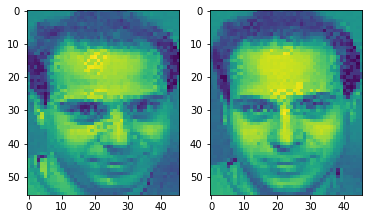

In [18]:
# we run the fgsm_siamese attack from attack_variants.ipynb to attack our face classification model
face_x_fgsm = fgsm_siamese(face_model, face_x_test, 0.05, np.inf,multi=True,loss_fn=my_contrastive_loss,y=face_y_test)
face_x_fgsm = process_adversarial_output(face_x_fgsm)
face_fgsm_acc, _, _, face_fgsm_loss = siamese_model_evaluate(face_model, face_x_fgsm, face_y_test, threshold=0.4)
print("Face Classification model accuracy and loss on adversarial examples: ",face_fgsm_acc, face_fgsm_loss)
fig, ax = plt.subplots(1,2)
ax[0].imshow(face_x_fgsm[0][0])
ax[1].imshow(face_x_fgsm[0][1])
plt.show()

In [19]:
del face_x_fgsm #save memory

This is an MNIST image before and after being converted into an adversarial example. The image on the right is confidently misclassified by our undefended MNIST model, despite clearly still being the same class.

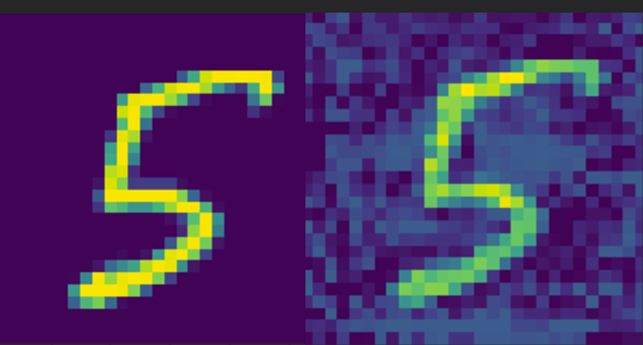

### Adversarial training pipeline

There are three steps to our adversarial training pipeline.

1) Save the original weights of the undefended model and save the path to the weights as a variable.  
2) Make a one-shot adversarial dataset for each of our four chosen attacks (FGSM, BIM, PGD, MIM).  
3) Train a model for each adversarial dataset (a model per attack type) and save the weights by adding the attack type and the level of adversarial training e.g. mnist_weights_fgsm_1.h5 for a one-shot learning model trained on an FGSM dataset.  

If you wish to experiment with datasets injected with more adversarial examples, change the 'level' hyperparameter of make_adv_datasets (levels are between 1-5). See 'data_utils.ipynb' for in-depth detail on how the adversarial datasets are generated and more detail on what each hyperparameter does.  

We analyse the performance of this approach in 'Experiment, Evaluation and Results.ipynb'.

In [6]:
mnist_model.save_weights('../models/mnist_weights/mnist_weights.h5')
mnist_weights_path = '../models/mnist_weights/mnist_weights.h5'
mnist_adv_datasets = make_adv_datasets(mnist_model,mnist_x_train,mnist_y_train,level=1,one_hot=False, eps=0.2, norm=np.inf, no_y=True)
mnist_adv_trained_models = adv_train_models(mnist_model,mnist_weights_path,mnist_adv_datasets, mnist_y_train,level=1,epochs=15)

In [7]:
traffic_model.save_weights('../models/traffic_weights/traffic_weights.h5')
traffic_weights_path = '../models/traffic_weights/traffic_weights.h5'
traffic_adv_datasets = make_adv_datasets(traffic_model,traffic_x_train,traffic_y_train,level=1,one_hot=True,eps=0.2, norm=np.inf, no_y=True)
traffic_adv_trained_models = adv_train_models(traffic_model,traffic_weights_path,traffic_adv_datasets, traffic_y_train,level=1,epochs=15)

In [ ]:
speech_model.save_weights('../models/speech_weights/speech_weights.h5')
speech_weights_path = '../models/speech_weights/speech_weights.h5'
speech_adv_datasets = make_adv_datasets(speech_model,speech_x_train,speech_y_train,level=1,one_hot=False,eps=0.2, norm=np.inf, no_y=True)
speech_adv_trained_models = adv_train_models(speech_model,speech_weights_path,speech_adv_datasets, speech_y_train,level=1,epochs=15)

## Training Siamese Adversarial Verification Neural Networks

In this section, we show how to develop siamese verification networks, our novel approach to providing adversarial robustness in a one-shot learning setting. Siamese neural networks have been shown to be effective at one-shot learning and classification, so we apply this to correctly classifying adversarial examples.

### Part One: Training on clean datasets

Firstly, for each undefended model, we create a paired dataset from the original dataset in the same way that we created our face classification dataset. Then, we build a siamese neural network via the architecture detailed in our report, which is also described in detail in 'training_utils.ipynb' through the build_siamese_model and get_siamese_model_architecture methods. We maintain the same architecture and hyperparameters for each of our models (excluding input shape) as we aim to create a widely applicable defence that can be effective without lots of experimentation with hyperparameters. After building the model, we train it on the paired dataset.

In [36]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1,
                              restore_best_weights=True)
callback_early_stop_reduceLROnPlateau=[earlyStopping]

In [62]:
(mnist_x_train_siamese, mnist_y_train_siamese) = get_siamese_dataset(mnist_x_train,mnist_y_train, expand_dims=True, one_hot=False, size=400, dataset_style=2)
(mnist_x_test_siamese, mnist_y_test_siamese) = get_siamese_dataset(mnist_x_test,mnist_y_test, expand_dims=True, one_hot=False, size=200, dataset_style=2)

In [63]:
mnist_x_train_siamese.shape

(20000, 2, 28, 28, 1)

In [330]:
mnist_model_siamese = get_siamese_model_architecture(mnist_x_test_siamese[0][0].shape,embedding_dim=128, conv_size=32,kernel_size=3)
mnist_siamese_model, mnist_siamese_history = train_siamese_model(mnist_model_siamese,mnist_x_train_siamese,mnist_y_train_siamese,mnist_x_test_siamese,mnist_y_test_siamese, batch_size=32,epochs=20)

Epoch 1/20
625/625 [==============================] - 14s 22ms/step - loss: 0.1841 - val_loss: 0.1314
Epoch 2/20
625/625 [==============================] - 17s 28ms/step - loss: 0.1242 - val_loss: 0.1017
Epoch 3/20
625/625 [==============================] - 15s 25ms/step - loss: 0.1021 - val_loss: 0.1064
Epoch 4/20
625/625 [==============================] - 15s 25ms/step - loss: 0.0904 - val_loss: 0.0976
Epoch 5/20
625/625 [==============================] - 16s 25ms/step - loss: 0.0830 - val_loss: 0.0930
Epoch 6/20
625/625 [==============================] - 16s 25ms/step - loss: 0.0776 - val_loss: 0.0935
Epoch 7/20
625/625 [==============================] - 16s 25ms/step - loss: 0.0739 - val_loss: 0.0908
Epoch 8/20
625/625 [==============================] - 17s 27ms/step - loss: 0.0702 - val_loss: 0.0919
Epoch 9/20
625/625 [==============================] - 18s 28ms/step - loss: 0.0680 - val_loss: 0.0892
Epoch 10/20
625/625 [==============================] - 18s 29ms/step - loss: 0.066

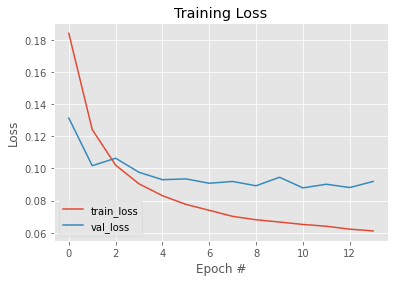

In [338]:
mnist_model_siamese.save_weights('../models/mnist_siamese_weights/mnist_siamese_weights.h5')
plot_training(mnist_siamese_history,'../graphs/history_mnist_siamese.png')

In [339]:
# observe precision and accuracy of the MNIST siamese model on clean data
mnist_siamese_pred = mnist_model_siamese.predict([mnist_x_test_siamese[:, 0], mnist_x_test_siamese[:, 1]])
print(compute_accuracy(mnist_siamese_pred,mnist_y_test_siamese))
mnist_siamese_pred_labels = mnist_siamese_pred.ravel() < 0.5
print(accuracy_score(mnist_y_test_siamese, mnist_siamese_pred_labels))

0.8978547530013777
0.9043


In [90]:
#create a traffic siamese model
traffic_x_train_siamese = []
traffic_x_test_siamese = []
(traffic_x_train_siamese, traffic_y_train_siamese) = get_siamese_dataset(traffic_x_train/255.,traffic_y_train, expand_dims=False, one_hot=True, size=400, dataset_style=2)
(traffic_x_test_siamese, traffic_y_test_siamese) = get_siamese_dataset(traffic_x_test/255.,traffic_y_test, expand_dims=False, one_hot=True, size=200, dataset_style=2)

In [340]:
traffic_model_siamese = get_siamese_model_architecture(traffic_x_test_siamese[0][0].shape,embedding_dim=128, conv_size=32,kernel_size=3)
traffic_siamese_model, traffic_siamese_history = train_siamese_model(traffic_model_siamese,traffic_x_train_siamese,traffic_y_train_siamese,traffic_x_test_siamese,traffic_y_test_siamese, batch_size=32,epochs=20)

Epoch 1/20
625/625 [==============================] - 19s 29ms/step - loss: 0.2062 - val_loss: 0.1721
Epoch 2/20
625/625 [==============================] - 15s 25ms/step - loss: 0.1642 - val_loss: 0.1593
Epoch 3/20
625/625 [==============================] - 15s 25ms/step - loss: 0.1388 - val_loss: 0.1339
Epoch 4/20
625/625 [==============================] - 17s 27ms/step - loss: 0.1219 - val_loss: 0.1321
Epoch 5/20
625/625 [==============================] - 19s 31ms/step - loss: 0.1106 - val_loss: 0.1177
Epoch 6/20
625/625 [==============================] - 20s 32ms/step - loss: 0.1024 - val_loss: 0.1107
Epoch 7/20
625/625 [==============================] - 20s 32ms/step - loss: 0.0969 - val_loss: 0.1116
Epoch 8/20
625/625 [==============================] - 21s 33ms/step - loss: 0.0930 - val_loss: 0.1168
Epoch 9/20
625/625 [==============================] - 21s 34ms/step - loss: 0.0897 - val_loss: 0.1054
Epoch 10/20
625/625 [==============================] - 21s 33ms/step - loss: 0.087

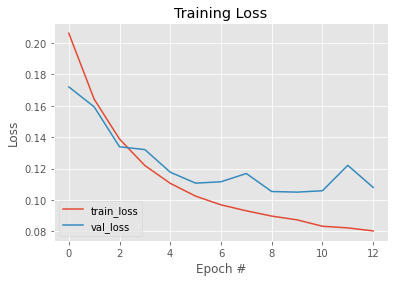

In [345]:
traffic_model_siamese.save_weights('../models/traffic_siamese_weights/traffic_siamese_weights.h5')
plot_training(traffic_siamese_history,'../graphs/history_traffic_siamese.png')

In [344]:
# we see our precision score
traffic_y_test_siamese[traffic_siamese_pred.ravel() < 0.4].mean()

0.8736992450520302

In [87]:
# and accuracy
traffic_siamese_pred_results = traffic_siamese_pred.ravel() < 0.5
accuracy_score(traffic_y_test_siamese, traffic_siamese_pred_results)

0.8236

In [40]:
#speech model siamese

#resize the large images into smaller 32x32 images, as in the standard CNN
speech_x_train_resized = resize_data(speech_x_train)
speech_x_train_resized = resize_data(speech_x_test)

In [254]:
(speech_x_train_siamese, speech_y_train_siamese) = get_siamese_dataset(speech_x_train_resized,speech_y_train, expand_dims=False, one_hot=False, size=800, dataset_style=2)
(speech_x_test_siamese, speech_y_test_siamese) = get_siamese_dataset(speech_x_test_resized,speech_y_test, expand_dims=False, one_hot=False, size=200, dataset_style=2)

In [258]:
speech_siamese_model = get_siamese_model_architecture(speech_x_test_siamese[0][0].shape, embedding_dim=128,conv_size=32,audio=False, kernel_size=3)
speech_siamese_model, speech_siamese_history = train_siamese_model(speech_siamese_model,speech_x_train_siamese,speech_y_train_siamese,speech_x_test_siamese,speech_y_test_siamese, batch_size=32,epochs=100)

Epoch 1/100
1250/1250 [==============================] - 34s 27ms/step - loss: 0.2676 - val_loss: 0.3745
Epoch 2/100
1250/1250 [==============================] - 37s 29ms/step - loss: 0.2565 - val_loss: 0.3728
Epoch 3/100
1250/1250 [==============================] - 37s 29ms/step - loss: 0.2552 - val_loss: 0.3409
Epoch 4/100
1250/1250 [==============================] - 37s 29ms/step - loss: 0.2467 - val_loss: 0.2777
Epoch 5/100
1250/1250 [==============================] - 37s 29ms/step - loss: 0.2350 - val_loss: 0.2584
Epoch 6/100
1250/1250 [==============================] - 37s 30ms/step - loss: 0.2219 - val_loss: 0.2278
Epoch 7/100
1250/1250 [==============================] - 37s 29ms/step - loss: 0.2133 - val_loss: 0.2291
Epoch 8/100
1250/1250 [==============================] - 37s 29ms/step - loss: 0.2036 - val_loss: 0.2165
Epoch 9/100
1250/1250 [==============================] - 37s 30ms/step - loss: 0.1972 - val_loss: 0.2039
Epoch 10/100
1250/1250 [==============================]

In [270]:
# our speech model's accuracy on clean data- we observe lower accuracy than the other models, perhaps as the spectrogram images
# are all fairly similar
speech_siamese_pred_results = speech_siamese_pred.ravel() < 0.4 #going to switch to this way of computing accuracy as the OG is just wrong
accuracy_score(speech_y_train_siamese, speech_siamese_pred_results)

0.8091

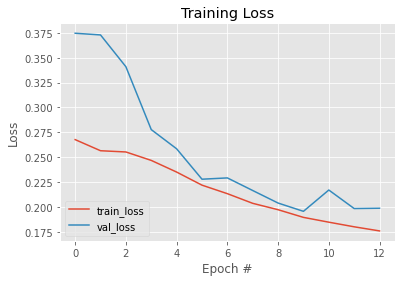

In [272]:
speech_siamese_model.save_weights('../models/speech_siamese_weights/speech_siamese_weights.h5')
plot_training(speech_siamese_history,'../graphs/history_speech_siamese.png')

In [291]:
# we also train a siamese verification network for the face model
face_siamese_model = get_siamese_model_architecture(face_x_test[0][0].shape, embedding_dim=128,conv_size=32,audio=False, kernel_size=3)
face_siamese_model, face_siamese_history = train_siamese_model(face_siamese_model,face_x_train,face_y_train,face_x_test,face_y_test, batch_size=32,epochs=100)

Epoch 1/100
469/469 [==============================] - 27s 56ms/step - loss: 0.1420 - val_loss: 0.1094
Epoch 2/100
469/469 [==============================] - 28s 60ms/step - loss: 0.1034 - val_loss: 0.0949
Epoch 3/100
469/469 [==============================] - 40s 85ms/step - loss: 0.0876 - val_loss: 0.0766
Epoch 4/100
469/469 [==============================] - 33s 71ms/step - loss: 0.0775 - val_loss: 0.0629
Epoch 5/100
469/469 [==============================] - 41s 87ms/step - loss: 0.0696 - val_loss: 0.0531
Epoch 6/100
469/469 [==============================] - 47s 100ms/step - loss: 0.0630 - val_loss: 0.0512
Epoch 7/100
469/469 [==============================] - 33s 71ms/step - loss: 0.0609 - val_loss: 0.0490
Epoch 8/100
469/469 [==============================] - 46s 98ms/step - loss: 0.0575 - val_loss: 0.0459
Epoch 9/100
469/469 [==============================] - 35s 74ms/step - loss: 0.0548 - val_loss: 0.0440
Epoch 10/100
469/469 [==============================] - 39s 83ms/step - 

In [292]:
face_siamese_pred = face_siamese_model.predict([face_x_test[:, 0], face_x_test[:, 1]])
print(compute_accuracy(face_siamese_pred,face_y_test))

0.9339587242026266


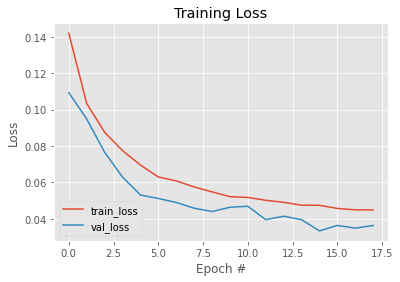

In [293]:
face_siamese_model.save_weights('../models/face_siamese_weights/face_siamese_weights.h5')
plot_training(face_siamese_history,'../graphs/history_face_siamese.png')

### Part two: one-shot adversarial training

As with our traditionally adversarially trained models, we now generate datasets with a single adversarial example for each original output class injected into the dataset. We then take a small sample of just 400 data points from that dataset (ensuring every output class is included at least once (and that the adversarial examples are included)) and generate a paired dataset of 20000 true/false pairs from this sample. In this way, the adversarial examples become more prominent in training than in traditional adversarial training. 

After creating the paired adversarial datasets, we train a siamese verification network model for each original task and for each attack type, as before.

In [41]:
# create the adversarial datasets for each original model
mnist_adv_train_datasets = make_adv_datasets(mnist_model,mnist_x_train,mnist_y_train,level=1,one_hot=False, eps=0.2, norm=np.inf)
mnist_adv_test_datasets = make_adv_datasets(mnist_model,mnist_x_test,mnist_y_test,level=4,one_hot=False, eps=0.2, norm=np.inf)

traffic_adv_train_datasets = make_adv_datasets(traffic_model,traffic_x_train,traffic_y_train,level=1,one_hot=True, eps=0.2, norm=np.inf)
traffic_adv_test_datasets = make_adv_datasets(traffic_model,traffic_x_test,traffic_y_test,level=4,one_hot=True, eps=0.2, norm=np.inf)

speech_adv_train_datasets = make_adv_datasets(speech_model,speech_x_train,speech_y_train,level=1,one_hot=False, eps=0.2, norm=np.inf)
speech_adv_test_datasets = make_adv_datasets(speech_model,speech_x_test,speech_y_test,level=4,one_hot=False, eps=0.2, norm=np.inf)

In [9]:
# we resize the speech spectrograms to 32x32, as they are resized to this size inside the original undefended CNN model.

speech_adv_train_datasets_resized = []
speech_adv_test_datasets_resized = []
for dataset in speech_adv_train_datasets:
    resized_data = resize_data(dataset[0])
    speech_adv_train_datasets_resized.append([resized_data,dataset[1]])
for dataset in speech_adv_test_datasets:
    resized_data = resize_data(dataset[0])
    speech_adv_test_datasets_resized.append([resized_data,dataset[1]])

In [43]:
# delete unnecessary data to save storage space
del speech_adv_train_datasets
del speech_adv_test_datasets

In [45]:
# create paired datasets from the adversarial datasets
mnist_adv_train_datasets_siamese, mnist_adv_test_datasets_siamese = get_siamese_datasets(mnist_adv_train_datasets,mnist_adv_test_datasets,expand_dims=True)
traffic_adv_train_datasets_siamese, traffic_adv_test_datasets_siamese = get_siamese_datasets(traffic_adv_train_datasets,traffic_adv_test_datasets)
speech_adv_train_datasets_siamese, speech_adv_test_datasets_siamese = get_siamese_datasets(speech_adv_train_datasets_resized,speech_adv_test_datasets_resized)

In [49]:
np.asarray(mnist_adv_train_datasets_siamese[0][0][0]).shape

(2, 28, 28, 1)

In [57]:
# training our siamese verification networks- one for each type of attack
mnist_siamese_model_architecture = get_siamese_model_architecture(np.asarray(mnist_adv_train_datasets_siamese[0][0][0][0]).shape, embedding_dim=128,conv_size=32,audio=False, kernel_size=3)
mnist_siamese_model_architecture.load_weights('../models/mnist_siamese_weights/mnist_siamese_weights.h5')
mnist_siamese_path = '../models/mnist_siamese_weights/mnist_siamese_weights.h5'

mnist_siamese_models, mnist_siamese_histories = adv_train_siamese_models(mnist_siamese_model_architecture,mnist_siamese_path,mnist_adv_train_datasets_siamese, mnist_adv_test_datasets_siamese,level=1, attacks=['fgsm','bim','pgd','mim'],batch_size=32,epochs=100)

fgsm model
Epoch 1/100
625/625 [==============================] - 25s 37ms/step - loss: 0.1047 - val_loss: 0.2044
Epoch 2/100
625/625 [==============================] - 23s 36ms/step - loss: 0.0858 - val_loss: 0.1996
Epoch 3/100
625/625 [==============================] - 23s 37ms/step - loss: 0.0769 - val_loss: 0.1860
Epoch 4/100
625/625 [==============================] - 23s 37ms/step - loss: 0.0713 - val_loss: 0.2044
Epoch 5/100
625/625 [==============================] - 27s 43ms/step - loss: 0.0675 - val_loss: 0.2054
Epoch 6/100
625/625 [==============================] - 29s 46ms/step - loss: 0.0638 - val_loss: 0.1996
Epoch 6: early stopping
bim model
Epoch 1/100
625/625 [==============================] - 29s 46ms/step - loss: 0.1074 - val_loss: 0.1487
Epoch 2/100
625/625 [==============================] - 28s 45ms/step - loss: 0.0885 - val_loss: 0.1431
Epoch 3/100
625/625 [==============================] - 28s 45ms/step - loss: 0.0804 - val_loss: 0.1414
Epoch 4/100
625/625 [=======

In [59]:
traffic_siamese_model_architecture = get_siamese_model_architecture(np.asarray(traffic_adv_train_datasets_siamese[0][0][0][0]).shape, embedding_dim=128,conv_size=32,audio=False, kernel_size=3)
traffic_siamese_model_architecture.load_weights('../models/traffic_siamese_weights/traffic_siamese_weights.h5')
traffic_siamese_path = '../models/traffic_siamese_weights/traffic_siamese_weights.h5'

traffic_siamese_models, traffic_siamese_histories = adv_train_siamese_models(traffic_siamese_model_architecture,traffic_siamese_path,traffic_adv_train_datasets_siamese, traffic_adv_test_datasets_siamese,level=1, attacks=['fgsm','bim','pgd','mim'],batch_size=32,epochs=100)

fgsm model
Epoch 1/100
625/625 [==============================] - 44s 68ms/step - loss: 0.1258 - val_loss: 0.1725
Epoch 2/100
625/625 [==============================] - 35s 56ms/step - loss: 0.1064 - val_loss: 0.1758
Epoch 3/100
625/625 [==============================] - 35s 57ms/step - loss: 0.0988 - val_loss: 0.1654
Epoch 4/100
625/625 [==============================] - 35s 57ms/step - loss: 0.0925 - val_loss: 0.1649
Epoch 5/100
625/625 [==============================] - 36s 57ms/step - loss: 0.0889 - val_loss: 0.1719
Epoch 6/100
625/625 [==============================] - 36s 58ms/step - loss: 0.0855 - val_loss: 0.1685
Epoch 7/100
625/625 [==============================] - 36s 57ms/step - loss: 0.0826 - val_loss: 0.1702
Epoch 7: early stopping
bim model
Epoch 1/100
625/625 [==============================] - 39s 63ms/step - loss: 0.1226 - val_loss: 0.1448
Epoch 2/100
625/625 [==============================] - 36s 57ms/step - loss: 0.1050 - val_loss: 0.1358
Epoch 3/100
625/625 [=======

In [61]:
speech_siamese_model_architecture = get_siamese_model_architecture(np.asarray(speech_adv_train_datasets_siamese[0][0][0][0]).shape, embedding_dim=128,conv_size=32,audio=False, kernel_size=3)
speech_siamese_model_architecture.load_weights('speech_siamese_weights_undefended2.h5')
speech_siamese_model_architecture.save_weights('speech_siamese_weights.h5')
speech_siamese_path = 'speech_siamese_weights.h5'

speech_siamese_models, speech_siamese_histories = adv_train_siamese_models(speech_siamese_model_architecture,speech_siamese_path,speech_adv_train_datasets_siamese, speech_adv_test_datasets_siamese,level=1, attacks=['fgsm','bim','pgd','mim'],batch_size=32,epochs=100)

fgsm model
Epoch 1/100
625/625 [==============================] - 27s 43ms/step - loss: 0.2056 - val_loss: 0.2591
Epoch 2/100
625/625 [==============================] - 29s 46ms/step - loss: 0.1916 - val_loss: 0.2728
Epoch 3/100
625/625 [==============================] - 31s 50ms/step - loss: 0.1802 - val_loss: 0.2491
Epoch 4/100
625/625 [==============================] - 32s 52ms/step - loss: 0.1722 - val_loss: 0.2567
Epoch 5/100
625/625 [==============================] - 32s 52ms/step - loss: 0.1691 - val_loss: 0.2652
Epoch 6/100
625/625 [==============================] - 33s 52ms/step - loss: 0.1619 - val_loss: 0.2539
Epoch 6: early stopping
bim model
Epoch 1/100
625/625 [==============================] - 35s 57ms/step - loss: 0.2147 - val_loss: 0.2653
Epoch 2/100
625/625 [==============================] - 33s 52ms/step - loss: 0.1983 - val_loss: 0.2550
Epoch 3/100
625/625 [==============================] - 33s 52ms/step - loss: 0.1901 - val_loss: 0.2471
Epoch 4/100
625/625 [=======

### Initial analysis

Below, we here we view some raw metrics to see how our siamese verification networks perform on adversarial data, but the performance is truly evaluated in the 'Experiment, Evaluation and Results.ipynb' notebook, where we compare the performance of our approach against traditional adversarial training. However, we generally see reasonably strong adversarial robustness from each model, especially when considering the extremely limited adversarial training. Performance also never drastically drops when a model is defending against an attack it did not specifically train for, showing transferability and generalisability. The attack the model trained for is displayed in the weights title of the model.

In [141]:
attacks = ['FGSM','BIM','PGD','MIM']

mnist_siamese_evals = attack_siamese_models(mnist_siamese_models,mnist_adv_test_datasets_siamese, threshold=0.4)

mnist_siamese_weights.h5

Model: mnist_siamese_weights.h5
FGSM : Accuracy  0.6076 Precision  0.6110193974411886 AUC  0.6076  Loss  0.24710351
BIM : Accuracy  0.6975 Precision  0.7201783723522854 AUC  0.6975  Loss  0.18583378
PGD : Accuracy  0.6595 Precision  0.6654221115951048 AUC  0.6595  Loss  0.22023655
MIM : Accuracy  0.6267 Precision  0.6392001757855417 AUC  0.6266999999999999  Loss  0.23134649
mnist_siamese_weights_fgsm_1.h5

Model: mnist_siamese_weights_fgsm_1.h5
FGSM : Accuracy  0.7036 Precision  0.7252212389380531 AUC  0.7036  Loss  0.18599272
BIM : Accuracy  0.8129 Precision  0.8604008293020041 AUC  0.8129  Loss  0.13362186
PGD : Accuracy  0.7767 Precision  0.7986186056550831 AUC  0.7767  Loss  0.158763
MIM : Accuracy  0.7206 Precision  0.7324062368310156 AUC  0.7206  Loss  0.18562129
mnist_siamese_weights_bim_1.h5

Model: mnist_siamese_weights_bim_1.h5
FGSM : Accuracy  0.6706 Precision  0.6784518828451883 AUC  0.6706000000000001  Loss  0.2115013
BIM : Accuracy  0.8185 Precis

In [140]:
traffic_siamese_evals = attack_siamese_models(traffic_siamese_models,traffic_adv_test_datasets_siamese, threshold=0.4)


Model: traffic_siamese_weights.h5
FGSM : Accuracy  0.6861 Precision  0.6845131865952806 AUC  0.6860999999999999  Loss  0.21690178
BIM : Accuracy  0.7464 Precision  0.7592592592592593 AUC  0.7464000000000001  Loss  0.17090935
PGD : Accuracy  0.7066 Precision  0.694319036869827 AUC  0.7066000000000001  Loss  0.2087649
MIM : Accuracy  0.6909 Precision  0.6888976845438354 AUC  0.6909000000000001  Loss  0.20521767

Model: traffic_siamese_weights_fgsm_1.h5
FGSM : Accuracy  0.7404 Precision  0.7822921559417567 AUC  0.7404  Loss  0.16488293
BIM : Accuracy  0.8281 Precision  0.8603118822754228 AUC  0.8281  Loss  0.12675641
PGD : Accuracy  0.7453 Precision  0.7476277003836059 AUC  0.7453  Loss  0.16714811
MIM : Accuracy  0.7769 Precision  0.7947626144347456 AUC  0.7769  Loss  0.15835531

Model: traffic_siamese_weights_bim_1.h5
FGSM : Accuracy  0.7145 Precision  0.7249842668344871 AUC  0.7145  Loss  0.1797397
BIM : Accuracy  0.7931 Precision  0.828956228956229 AUC  0.7930999999999999  Loss  0.13

In [137]:
speech_siamese_evals = attack_siamese_models(speech_siamese_models,speech_adv_test_datasets_siamese, threshold=0.4)


Model: speech_siamese_weights.h5
FGSM : Accuracy  0.5648 Precision  0.5745513115508514 AUC  0.5648  Loss  0.29157892
BIM : Accuracy  0.5715 Precision  0.584575348947244 AUC  0.5715  Loss  0.2901115
PGD : Accuracy  0.5684 Precision  0.5856713426853707 AUC  0.5684  Loss  0.30699742
MIM : Accuracy  0.5602 Precision  0.5714964370546318 AUC  0.5602  Loss  0.3165685

Model: speech_siamese_weights_fgsm_1.h5
FGSM : Accuracy  0.616 Precision  0.5935785737334625 AUC  0.616  Loss  0.2490623
BIM : Accuracy  0.5994 Precision  0.5736732878742958 AUC  0.5993999999999999  Loss  0.2619273
PGD : Accuracy  0.6014 Precision  0.5778562653562653 AUC  0.6014  Loss  0.2611168
MIM : Accuracy  0.5735 Precision  0.5571984435797666 AUC  0.5735  Loss  0.26835364

Model: speech_siamese_weights_bim_1.h5
FGSM : Accuracy  0.6013 Precision  0.5885334731690264 AUC  0.6013  Loss  0.2499579
BIM : Accuracy  0.603 Precision  0.5895652173913043 AUC  0.603  Loss  0.24712166
PGD : Accuracy  0.586 Precision  0.5807360120165227